# Surface Analysis 

This notebook shows the process of creating a surface analyses using observational weather data.  Specifically, this notebook provides examples of:

1. Downloading recent and archived surface meteorological observations in netcdf format.
2. Reading observational data from netcdf datasets.
3. Quality controlling observational data.
4. Storing observational data in pandas dataframes.
5. Performing basic meteorological calculations.
6. Performing objective analysis and the impact of different radii of influence.
7. The impact of successive corrections objective analysis algorithms on surface analyses.
8. Plotting meteorological analyses using metpy.

This notebook allows users to input any time, date, and location to examine analyses for any event users find interesting.  This also allows users to examine how different objective analysis techniques perform in different meteorological situations.

### 1. Load required libraries

In [1]:
#suppress warnings
import warnings
warnings.filterwarnings("ignore")

#numpy library for working with numerical data
import numpy as np

#glob library for accessing the downloaded observational data
import glob

#datetime library for handing dates
from datetime import datetime, timedelta

#libraries for downloading observational data
import requests
import gzip
import shutil

#netcdf library for reading observational data
from netCDF4 import Dataset

#cartopy and matplotlib for plotting and visualization
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

#pandas for creating data frame
import pandas as pd

#various metpy functions and objects
from metpy.calc import reduce_point_density
import metpy.calc as mpcalc
from metpy.plots import StationPlot, wx_code_to_numeric
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units
from metpy.interpolate import interpolate_to_grid, remove_nan_observations, interpolate_to_points
from metpy.io import metar

### 2. Define the date, time, and location to analyze 

Here the user can input a date, time, latitude and longitude for the map to be plotted. Users can either define the bounds of the domain to be plotted or provide a single latitude, longitude point from which a default area will be drawn.

Example dates and locations:
1. Hurricane Michael Over Georgia
   - 2018 October 11 at 0600Z; location (lat,lon) = (32.5,-83.5)
2. Bomb Cyclone Over Kansas
   - 2019 March 14 at 0000Z; location (lat,lon) = (37.5,-98.5)


In [2]:
#set time to plot (no leading zeros)
start_year  = 2019
start_month = 3
start_day   = 14
start_hour  = 0
start_min   = 0
    
#location to plot
location = True
location_lat = 37.5
location_lon = -98.5
#    OR
#analysis bounds
#location = False
lat_min = 30
lat_max = 35
lon_min = -86
lon_max = -81

In [3]:
#set-up bounds
if location:
    lat_min = location_lat-3.5
    lat_max = location_lat+3.5
    lon_min = location_lon-3.5
    lon_max = location_lon+3.5

### 3. Determining Data URL

If requested date is recent (within the past 100 hours), the data is available via the recent MADIS dataset from NCEP:
 - https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/point/metar/netcdf/

Otherwise, data must be collected from the MADIS data archive from NCEP:
 - https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/
 
The data URL is printed to allow users to archive data directly if they choose.

In [4]:
#calculate number of hours since requested date
dt = datetime(start_year,start_month,start_day,start_hour,start_min)
del_t = datetime.now()-dt
del_t_days = del_t.days + (del_t.seconds/60/60/24)
del_t_hours = del_t_days * 24.

#if the requested date is over 100 days ago, use MADIS archive
if del_t_hours>100:
    base_url = 'https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/'
    url = f'{base_url}{dt:%Y}/{dt:%m}/{dt:%d}/point/metar/netcdf/{dt:%Y%m%d_%H%M}.gz'

#otherwise use MADIS recent data
else:
    base_url = 'https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/point/metar/netcdf/'
    url = f'{base_url}{dt:%Y%m%d_%H%M}.gz'

print(url)


https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/2019/03/14/point/metar/netcdf/20190314_0000.gz


### 4. Downloading Observational Data From Online
Observational data at the determined URL is downloaded to the local directory as a NETCDF4 formated dataset.  This data is stored as "temp.nc" to limit storage requirements.

In [5]:
#download dataset
r = requests.get(url,allow_redirects=True)
open('temp.nc.gz','wb').write(r.content)
#uncompress the observational data using g-zip
with gzip.open('temp.nc.gz','rb') as f_in:
    with open('temp.nc','wb') as f_out:
        shutil.copyfileobj(f_in,f_out)


### 5a. Open observational dataset and begin reading data

The data is stored such that times are recorded in "unix time" or the number of seconds since 0000Z on 1 January 1970.  Unix time is defined and time is converted using the "timedelta" function from the datetime library.

In [6]:
#open the netcdf dataset
data=Dataset('temp.nc','r')

#convert times
UNIX_TIME = datetime(1970,1,1,0)
time = [UNIX_TIME + timedelta(seconds=float(t)) for t in data['timeNominal']]

#read in latitude and longitude
#if no data is reported, fill those values with Not-A-Numbers
lat = data['latitude'][:]
lat = lat.filled(np.nan)
lon = data['longitude'][:]
lon = lon.filled(np.nan)

### 5b. Read in meteorological data and perform quality control

Check that the data makes sense.  If not, get rid of it.

In [7]:
# read in the name of the observation station
name = data['stationName'][:]
name = [i.tostring().decode()[:4] for i in name]

# read in temperature data (stored in Kelvin)
temp = data['temperature'][:]
temp = temp.filled(np.nan)
# if temperature is below 100 K, assume it's bad
# (record coldest temperature ever is 183 K)
temp[temp<100]=np.nan
# convert temperature to degrees Celsius
# *C = K - 273.15
temp = (temp-273.15)

# apply similar QC to dewpoint
dwpt = data['dewpoint'][:]
dwpt = dwpt.filled(np.nan)
dwpt[dwpt<100]=np.nan
dwpt = (dwpt-273.15)

# read in wind speed.  If over 250 m/s, assume it's bad
wspd = data['windSpeed'][:]
wspd = wspd.filled(np.nan)
wspd[wspd>250] = np.nan

# read in wind direction
wdir = data['windDir'][:]
wdir = wdir.filled(np.nan)
wdir[wdir<0] = np.nan

# read in wind gust
gust = data['windGust'][:]
gust = gust.filled(np.nan)
gust[gust<0] = np.nan

# read in sea level pressure as Pa and convert to hPa
pres = data['seaLevelPress'][:]/100.0
pres = pres.filled(np.nan)

### 5c. Read in Sky Cover and Present Weather

The metpy library has specific requirements for sky cover and present weather.  Sky cover must be provided as an integer value from 0 to 8, indicating the sky cover in octas.  Present weather is stored as a specific code.

The NETCDF4 dataset uses strings to indicate the sky cover, these are converted as follows:
 - CLR = 0 (0 octas; 0/8)
 - FEW = 2 (2 octas; 2/8)
 - SCT = 4 (4 octas; 4/8)
 - BKN = 6 (6 octas; 6/8)
 - OVC = 8 (8 octas; 8/8)

In [8]:
#read in sky cover
sky_cov = data['skyCover'][:]

#convert to strings
sky_cov = [(i[0].tostring().decode()).rstrip('\x00') for i in sky_cov]

#create new variable to hold the numerical translation
sky_cvr = np.zeros(len(sky_cov),dtype=int)

#translate to numerical
clr_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="CLR"]
sky_cvr[clr_inds] = 0
few_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="FEW"]
sky_cvr[few_inds] = 2
sct_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="SCT"]
sky_cvr[sct_inds] = 4
bkn_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="BKN"]
sky_cvr[bkn_inds] = 6
ovc_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="OVC"]
sky_cvr[ovc_inds] = 8


In [9]:
#read in present weather string
wx = data['presWeather'][:]

#convert to string
wx = [(i.tostring().decode()).rstrip('\x00') for i in wx]

#create new variable to hold the numerical translation
pres_wx = np.zeros(len(lat))

#if no present weather is reported, numerical translation = 0
#otherwise, perfrom numerical translation
for i in range(len(wx)):
    this_wx = wx[i].split()
    if this_wx == []:
        pres_wx[i] = 0
        continue
    pres_wx[i] = wx_code_to_numeric(this_wx)[0]
pres_wx = pres_wx.astype(int)

### 5d. Convert wind speed and direction to U,V components and convert from m/s to knots

In [10]:
#calculate u and v components of wind with MetPy
u,v = mpcalc.wind_components((wspd*units('m/s')).to('knots'),wdir*units.degree)

### 6. Store the variables into a pandas dataframe to allow for easier analysis

In [11]:
#place variables into dataframe to plot
df = pd.DataFrame(np.transpose(np.array([time,name,name,lon,lat,u,v,temp,dwpt,pres,sky_cvr,pres_wx])),
                      columns = ['time','id','name','lon','lat','u','v','temp','dwpt','pres','sky_cvr','wx'])


### 7. Trimming data outside of plotted area

This is done to decrease computing time.

In [12]:
print('drop data outside of domain')
to_drop = df[(df['lat'] > lat_max+10) | (df['lat'] < lat_min-10) | (df['lon'] > lon_max+10) | (df['lon'] < lon_min-10)].index
print('    dropped %i observations'%len(to_drop))
df_trim = df.drop(to_drop,inplace=False)
df_trim.set_index(['time','id'],inplace=True)

drop data outside of domain
    dropped 5071 observations


### 8. Analyze Surface Pressure

While meteorology students typically learn how to contour surface pressure using observations, this is done subjectively by estimating where the contours should be plotted.  Computers prefer to do things mathematically (objective analysis).

The code below uses the Cressman (1959) weighting function to perform objective analysis.

The analysis options are:
 - hres = the horizontal resolution of the analysis in meters; 20,000 is good for zoomed in areas, larger values can speed up 
 - search_radius = use observations if they are closer to the analysis point than this value in meters (larger value uses more observations); 300,000m is a good value, but make sure to see the impact of different radii

In [13]:
hres = 20000
search_radius = 300000

#define projection
proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)

#remove data without sea level pressure observations
slpdf = df_trim.dropna(subset=['pres'],inplace=False)

point_locs_slp = proj.transform_points(ccrs.PlateCarree(),slpdf['lon'].values,slpdf['lat'].values)

xp,yp,null = point_locs_slp.T
    
slpgridx, slpgridy, slp = interpolate_to_grid(xp,yp,slpdf['pres'],
                                              interp_type='cressman',
                                              minimum_neighbors=1,hres=hres,
                                              search_radius=search_radius)

### 9. Plot Analysis

Plot the sea level pressure analysis on a map along with station plots.

Options:
 - point_density = the density of surface station plots to include (in meters; 30,000 is a good starting point)

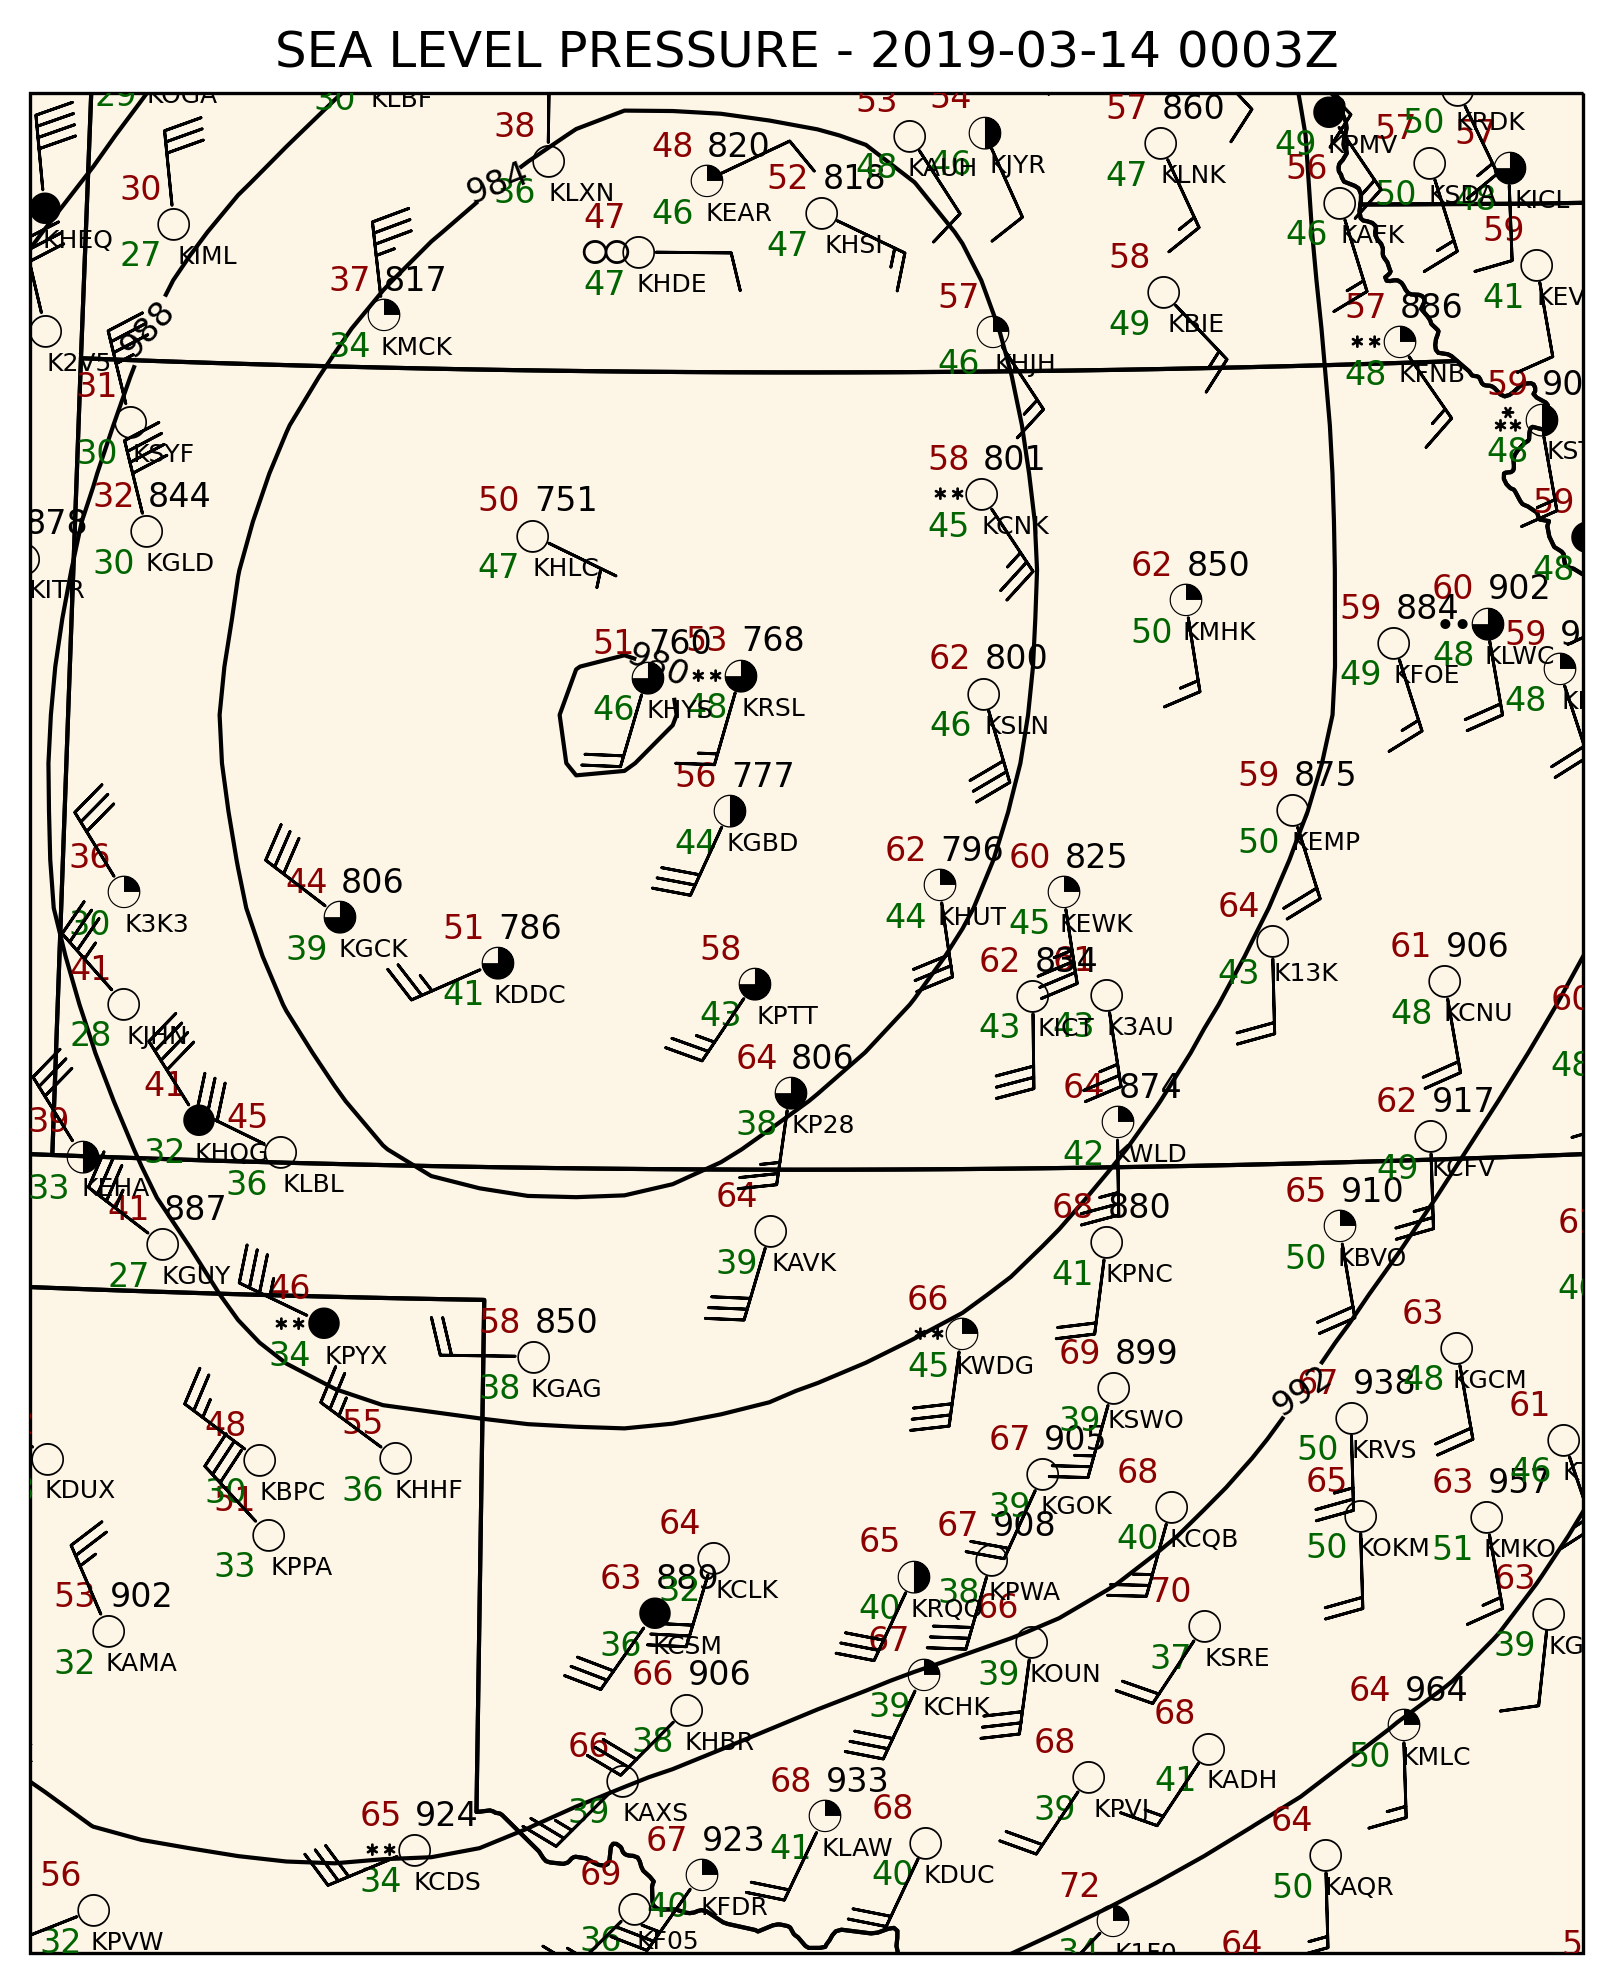

In [14]:
point_density = 30000.

#declutter surface station plots
point_locs = proj.transform_points(ccrs.PlateCarree(),df_trim['lon'].values,df_trim['lat'].values)
df_plot = df_trim[reduce_point_density(point_locs,point_density)]

#set up map
fig=plt.figure(figsize=(11,6.5),dpi=300)
ax = fig.add_subplot(1,1,1,projection=proj)
ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m',facecolor='oldlace'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','lakes','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

#plot station plots
stationplot = StationPlot(ax,df_plot['lon'].values,df_plot['lat'].values,clip_on=True, transform=ccrs.PlateCarree(),fontsize=8)
stationplot.plot_parameter('NW',df_plot['temp']*(9.0/5.0)+32.0,color='darkred',fontsize=8)
stationplot.plot_parameter('NE',df_plot['pres'],color='black',formatter=lambda v: format(10 * v, '.0f')[-3:],fontsize=8)
stationplot.plot_parameter('SW',df_plot['dwpt']*(9.0/5.0)+32.0,color='darkgreen',fontsize=8)
stationplot.plot_text('SE',df_plot['name'].values,color='k',fontsize=6)
stationplot.plot_barb(np.array(df_plot['u'].values,dtype=float),np.array(df_plot['v'].values,dtype=float),linewidth=0.7,length=6,zorder=10)
stationplot.plot_symbol('C',df['sky_cvr'].values,sky_cover)
stationplot.plot_symbol('W',df['wx'].values,current_weather,fontsize=12)

#plot presure contours
cs = plt.contour(slpgridx,slpgridy,slp,colors='k',levels=list(range(900,1046,4)),linewidths=1)
plt.clabel(cs, inline=1, fontsize=8, fmt='%i')

fig.tight_layout()
plt.title('SEA LEVEL PRESSURE - %sZ'%dt.strftime('%Y-%m-%d %H%m'))
plt.show()

## Advanced Analysis

The cells below are more for demonstration of more advanced analyses.  This includes successive corrections methods of objective analysis.

### 10. Perform successive corrections

The above analysis is a single pass algorithm.  While useful, these can suffer from several disadvantages such as biasing towards areas of high data density.  Koch et al. (1983) showed using multiple passes, with the previous pass acting as a guess that is successively corrected, can lead to better analyses.

With the single pass, you must choose between a large search radius which gives smooth features, or a small search radius which can analyze fine features, but loses the large features.  With a multiple pass, successive corrections algorithm both the large scale features and small scale features can be analyzed.

In [15]:
hres = 20000
search_radii = [300000,200000,200000]

proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)

slpdf = df_trim.dropna(subset=['pres'],inplace=False)
    
point_locs_slp = proj.transform_points(ccrs.PlateCarree(),slpdf['lon'].values,slpdf['lat'].values)

xp,yp,null = point_locs_slp.T
    
#perform first pass
slpgridx, slpgridy, slp = interpolate_to_grid(xp,yp,slpdf['pres'],
                                              interp_type='cressman',
                                              minimum_neighbors=1,hres=hres,search_radius=search_radii[0])
SLP = np.zeros((len(search_radii),len(slp),len(slp[0])))
SLP[0] = slp
grid = np.transpose([slpgridx.ravel(),slpgridy.ravel()])
stns = np.transpose([xp,yp])
for i in range(1,len(search_radii)):
    #interpolate gridded slp to obs locations:
    slp_bg = interpolate_to_points(grid,SLP[i-1].ravel(),stns,interp_type='cressman',search_radius=search_radii[i-1])
        
    #calculate next pass
    slpgridx, slpgridy, slp = interpolate_to_grid(xp,yp,slpdf['pres']-slp_bg,interp_type='cressman',minimum_neighbors=1,hres=hres,search_radius=search_radii[i])
    SLP[i] = np.nansum([slp,SLP[i-1]],axis=0)
    slp = SLP[i]

### 11. Plot the first and final pass


In [ ]:
point_density = 30000.

#declutter surface station plots
point_locs = proj.transform_points(ccrs.PlateCarree(),df_trim['lon'].values,df_trim['lat'].values)
df_plot = df_trim[reduce_point_density(point_locs,point_density)]

#set up map
fig=plt.figure(figsize=(11,13),dpi=300)
ax = fig.add_subplot(1,2,1,projection=proj)
ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m',facecolor='oldlace'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','lakes','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

#plot station plots
stationplot = StationPlot(ax,df_plot['lon'].values,df_plot['lat'].values,clip_on=True, transform=ccrs.PlateCarree(),fontsize=8)
stationplot.plot_parameter('NW',df_plot['temp']*(9.0/5.0)+32.0,color='darkred',fontsize=8)
stationplot.plot_parameter('NE',df_plot['pres'],color='black',formatter=lambda v: format(10 * v, '.0f')[-3:],fontsize=8)
stationplot.plot_parameter('SW',df_plot['dwpt']*(9.0/5.0)+32.0,color='darkgreen',fontsize=8)
stationplot.plot_text('SE',df_plot['name'].values,color='k',fontsize=6)
stationplot.plot_barb(np.array(df_plot['u'].values,dtype=float),np.array(df_plot['v'].values,dtype=float),linewidth=0.7,length=6,zorder=10)
stationplot.plot_symbol('C',df['sky_cvr'].values,sky_cover)
stationplot.plot_symbol('W',df['wx'].values,current_weather,fontsize=12)

#plot presure contours
cs = plt.contour(slpgridx,slpgridy,SLP[0],colors='k',levels=list(range(900,1046,4)),linewidths=1)
plt.clabel(cs, inline=1, fontsize=8, fmt='%i')
plt.title('PASS 1')

ax = fig.add_subplot(1,2,2,projection=proj)
ax.add_feature(cfeature.NaturalEarthFeature('physical','land','50m',facecolor='oldlace'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.NaturalEarthFeature('physical','lakes','50m',facecolor='lightcyan'))
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent((lon_min,lon_max,lat_min,lat_max))

#plot station plots
stationplot = StationPlot(ax,df_plot['lon'].values,df_plot['lat'].values,clip_on=True, transform=ccrs.PlateCarree(),fontsize=8)
stationplot.plot_parameter('NW',df_plot['temp']*(9.0/5.0)+32.0,color='darkred',fontsize=8)
stationplot.plot_parameter('NE',df_plot['pres'],color='black',formatter=lambda v: format(10 * v, '.0f')[-3:],fontsize=8)
stationplot.plot_parameter('SW',df_plot['dwpt']*(9.0/5.0)+32.0,color='darkgreen',fontsize=8)
stationplot.plot_text('SE',df_plot['name'].values,color='k',fontsize=6)
stationplot.plot_barb(np.array(df_plot['u'].values,dtype=float),np.array(df_plot['v'].values,dtype=float),linewidth=0.7,length=6,zorder=10)
stationplot.plot_symbol('C',df['sky_cvr'].values,sky_cover)
stationplot.plot_symbol('W',df['wx'].values,current_weather,fontsize=12)

#plot presure contours
cs = plt.contour(slpgridx,slpgridy,SLP[-1],colors='k',levels=list(range(900,1046,4)),linewidths=1)
plt.clabel(cs, inline=1, fontsize=8, fmt='%i')
plt.title('PASS %i'%len(SLP))

fig.tight_layout()

plt.show()

#### References:

#### Author Information

     - Josh Nielsen
     - Jared W. Marquis (jared.marquis@UND.edu)